## Suppl. Fig. 3 panel C tenary plots


In [1]:
import pandas as pd
import ternary
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
import plotly.io as pio
import math
import os
import seaborn as sns
from datetime import datetime
from pathlib import Path
import sys
plt.rcParams['pdf.fonttype'] = 42 # for illustrator

script_path = Path.cwd().parent.parent.parent.parent / "script"
data_path = Path.cwd().parent.parent.parent.parent / "data"
sys.path.append(str(script_path))
from utils.label_processing import attach_annotations

save_path = Path.cwd() / "output"
if not os.path.exists(save_path):
    os.makedirs(save_path)

## load data

In [2]:
# timestamp = datetime.now().strftime('%Y-%m-%d')
# print(f"Timestamp: {timestamp}")    

In [3]:
# manually set the timestamp to use the intermediate results from another date
timestamp = "2023-12-04"

In [4]:
# define files to load
enrichment_dir = Path.cwd().parent.parent.parent / "enrichment"
enrichment_csv_path = enrichment_dir / "output" / "enrichment_and_volcano_tables" / f'{timestamp}_enrichment_table_NOC_prop.csv'

try:
    # load the file
    enrichments = pd.read_csv(enrichment_csv_path, header=[0,1], index_col=0)
except FileNotFoundError:
    print(f"File {enrichment_csv_path} not found.\nPlease run the enrichment analysis first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {enrichment_csv_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [5]:
# attach labels
labels_csv = Path.cwd().parent.parent.parent / "Fig2" / "panel_C" / "output" / "2023-12-04_annotations.csv"

lookup_table = pd.read_csv(labels_csv)
to_df = enrichments["metadata"].copy()
list_of_cols_to_add = reversed(["cluster_annotation","Graph-based_localization_annotation","Protein-level_consensus_annotation"])
for c in list_of_cols_to_add:
    new_col_data = attach_annotations(from_df=lookup_table, to_df=to_df, anno_col=c , from_on="Majority protein IDs", to_on="Majority protein IDs")
    enrichments.insert(2, ("metadata", c), new_col_data)
    #enrichments[("metadata", c)] = new_col_data


In [6]:
df = enrichments.droplevel(0, axis=1)

## group proteins
- cytosolic
- nucleus
- membrane-bound compartments: mitochondria, peroxisomes, ER, ERGIC, Golgi, trans-Golgi, early endosome endosomes, recycling endosome, plasma membrane, lysosomes

In [7]:
labels_used_to_group = "cluster_annotation" # other options: "Graph-based_localization_annotation", "Protein-level_consensus_annotation"

In [8]:
# check labels
df[labels_used_to_group].unique()

array(['nucleus', 'Golgi', 'cytosol', 'trans-Golgi', 'early_endosome',
       'stress_granule', 'unclassified', 'centrosome', 'ER',
       'recycling_endosome', 'plasma_membrane', 'actin_cytoskeleton',
       'mitochondrion', 'lysosome', 'translation', 'nucleolus',
       '14-3-3_scaffold', 'peroxisome', 'p-body', 'ERGIC', 'proteasome',
       'spindle'], dtype=object)

In [9]:
# list of membrane bound compartment names
mbc = ['mitochondrion','peroxisome', 'ER', 'ERGIC', 'Golgi', 'trans-Golgi', 
       'early_endosome', 'recycling_endosome','plasma_membrane','lysosome']
# make sure there is no typo
assert all([x in df[labels_used_to_group].unique() for x in mbc])

In [10]:
# group proteins
df["group"] = df[labels_used_to_group].apply(lambda x: "membrane_bound_compartment" if x in mbc else 
                                           "cytosol" if x == "cytosol" else 
                                           "nucleus" if x == "nucleus" else
                                           "unclassified" if x=="unclassified" else "other")

In [13]:
df["group"].unique()

array(['nucleus', 'membrane_bound_compartment', 'cytosol', 'other',
       'unclassified'], dtype=object)

## ternary plots

In [11]:
# ternary plot parameters
scale = 1 
pointsize = 80

### ternary: scatterplot

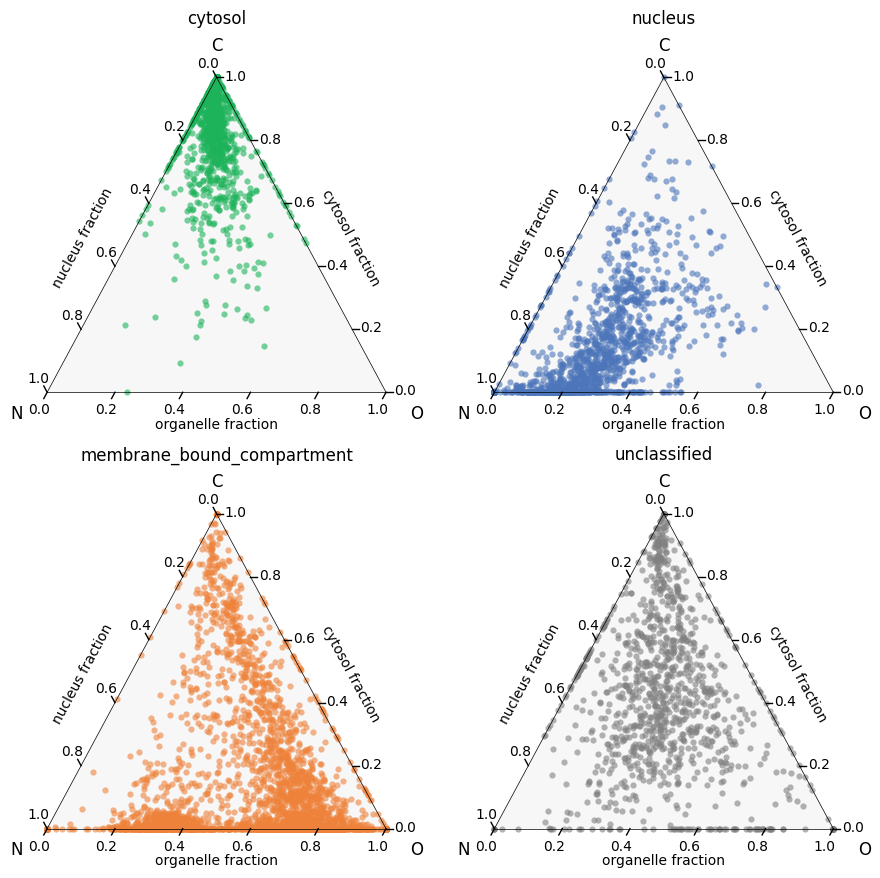

In [14]:
# plot the ternary plot
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=2, ncols=2)  
fig.set_size_inches(10, 10) # Set the figure size to letter size (8.5 x 11 inches)
fig.subplots_adjust(left=0.08, bottom = 0.08) # set the left and bottom margin for x and y axis labels

groups = ["cytosol", "nucleus", "membrane_bound_compartment", "unclassified"]
colors = ["#1DB35A", "#4C75BA", "#EE823A", "grey"]

idx = 0
for r in range(nrows):
    for c in range(ncols):
        group = groups[idx]
        tmp_df = df[df["group"]==group]
        points = list(zip(tmp_df["NOC_organelle"], tmp_df["NOC_cytosol"],  tmp_df["NOC_nuclear"]))

        tax = ternary.TernaryAxesSubplot(ax=axs[r,c], scale=scale)
        tax.boundary(linewidth=0.5)
        tax.scatter(points, marker='.', color=colors[idx], label=group, alpha=0.6, s=pointsize, linewidths=0, edgecolors=None)
        tax.left_axis_label("nucleus fraction", fontsize=10, offset = 0.15)
        tax.right_axis_label("cytosol fraction", fontsize=10, offset = 0.15)
        tax.bottom_axis_label("organelle fraction", fontsize=10, offset = 0)
        tax.ticks(axis='lbr', linewidth=1, multiple=0.2, tick_formats="%.1f", offset=0.02)
        tax.right_corner_label("O", fontsize=12, offset=0.15, va='top')
        tax.top_corner_label("C", fontsize=12, offset=0.2)
        tax.left_corner_label("N", fontsize=12, offset=0.15, va='top')
        tax.clear_matplotlib_ticks()
        tax.set_title(group, fontsize=12, x=0.5, y=1.09)

        for spine in axs[r,c].spines.values():
            spine.set_visible(False)
        
        idx += 1

# save figure
fig.savefig( save_path / f"{timestamp}_ternery_subplots.pdf", dpi=300, bbox_inches='tight', format="pdf")


### tenary: percentile contour lines

preprocess tenary data

In [16]:
cyto_df = df[df["group"]=="cytosol"]
nuc_df = df[df["group"]=="nucleus"]
mbc_df = df[df["group"]=="membrane_bound_compartment"]
unclassified_df = df[df["group"]=="unclassified"]

cyto_points = list(zip(cyto_df["NOC_organelle"], cyto_df["NOC_cytosol"],  cyto_df["NOC_nuclear"]))
nuc_points = list(zip(nuc_df["NOC_organelle"], nuc_df["NOC_cytosol"],  nuc_df["NOC_nuclear"]))
mbc_points = list(zip(mbc_df["NOC_organelle"], mbc_df["NOC_cytosol"],  mbc_df["NOC_nuclear"]))
unclassified_points = list(zip(unclassified_df["NOC_organelle"], unclassified_df["NOC_cytosol"],  unclassified_df["NOC_nuclear"]))


compute cartesian coordinates (for contour lines estimation)

In [19]:
def ternary_to_cartesian(ternary_points):
    cartesian_points = []
    for a, b, c in ternary_points:
        x = 0.5 * (2*b + c)
        y = (math.sqrt(3) / 2) * c
        cartesian_points.append((x, y))
    return cartesian_points

cyto_tenary_in_cart = ternary_to_cartesian(list(zip(cyto_df["NOC_nuclear"], cyto_df["NOC_organelle"], cyto_df["NOC_cytosol"])))
nuc_tenary_in_car = ternary_to_cartesian(list(zip(nuc_df["NOC_nuclear"],nuc_df["NOC_organelle"], nuc_df["NOC_cytosol"])))
mbc_tenary_in_car = ternary_to_cartesian(list(zip(mbc_df["NOC_nuclear"], mbc_df["NOC_organelle"],  mbc_df["NOC_cytosol"])))
unclassified_tenary_in_car = ternary_to_cartesian(list(zip(unclassified_df["NOC_nuclear"], unclassified_df["NOC_organelle"],  unclassified_df["NOC_cytosol"])))


put cartesian coords in a dataframe for sns

In [20]:
x = list(np.array(cyto_tenary_in_cart)[:,0]) + list(np.array(nuc_tenary_in_car)[:,0]) + list(np.array(mbc_tenary_in_car)[:,0]) + list(np.array(unclassified_tenary_in_car)[:,0])
y = list(np.array(cyto_tenary_in_cart)[:,1]) + list(np.array(nuc_tenary_in_car)[:,1]) + list(np.array(mbc_tenary_in_car)[:,1]) + list(np.array(unclassified_tenary_in_car)[:,1])
group = ["cytosol"]*len(cyto_df) + ["nucleus"]*len(nuc_df) + ["membrane_bound_compartment"]*len(mbc_df) + ["unclassified"]*len(unclassified_df)
kde_df = pd.DataFrame({"x":x, "y":y, "group":group})

visually verify cartesian coordinates

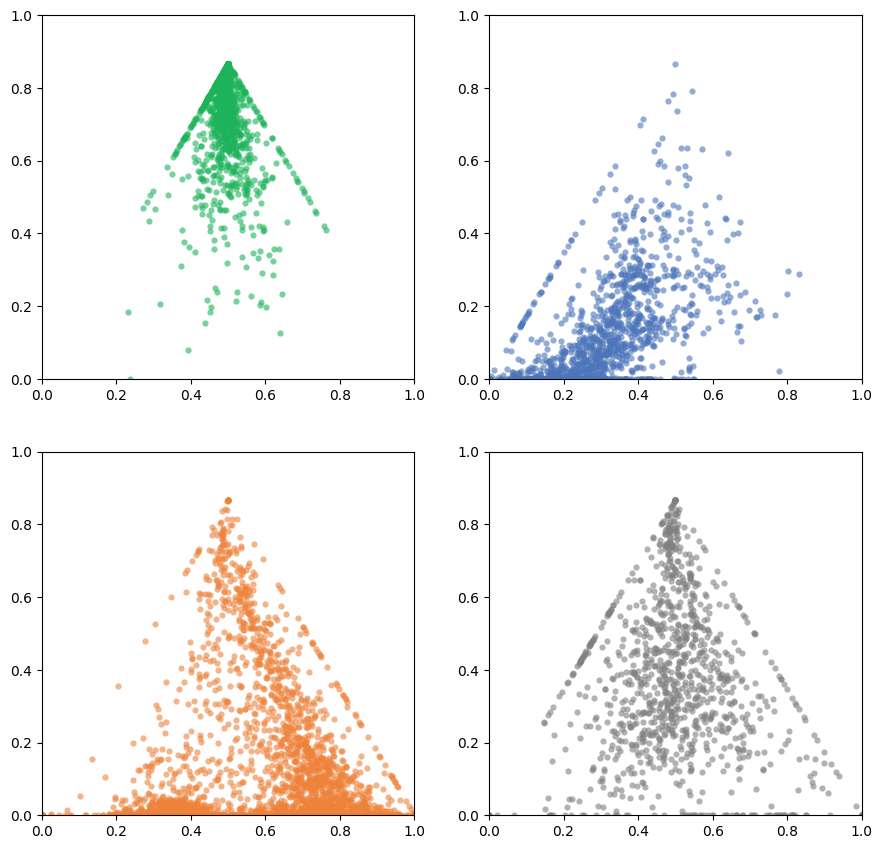

In [21]:
# plot the ternary plot
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=2, ncols=2)  
fig.set_size_inches(10, 10) # Set the figure size to letter size (8.5 x 11 inches)
fig.subplots_adjust(left=0.08, bottom = 0.08) # set the left and bottom margin for x and y axis labels

groups = ["cytosol", "nucleus", "membrane_bound_compartment", "unclassified"]
colors = ["#1DB35A", "#4C75BA", "#EE823A", "grey"]

idx = 0
for r in range(nrows):
    for c in range(ncols):
        group = groups[idx]
        tmp_df = kde_df[kde_df["group"]==group]
        axs[r,c].scatter(tmp_df["x"], tmp_df["y"], marker='.', color=colors[idx], label=group, alpha=0.6, s=pointsize, linewidths=0, edgecolors=None)
        axs[r,c].set_ylim(0, 1)
        axs[r,c].set_xlim(0, 1)
        idx += 1

draw the percentile contour lines, aka iso-proportion level lines  
setting thres to 0.2 and levels to 9, means that first line is drawn at 20%, and draw 9 lines in total.

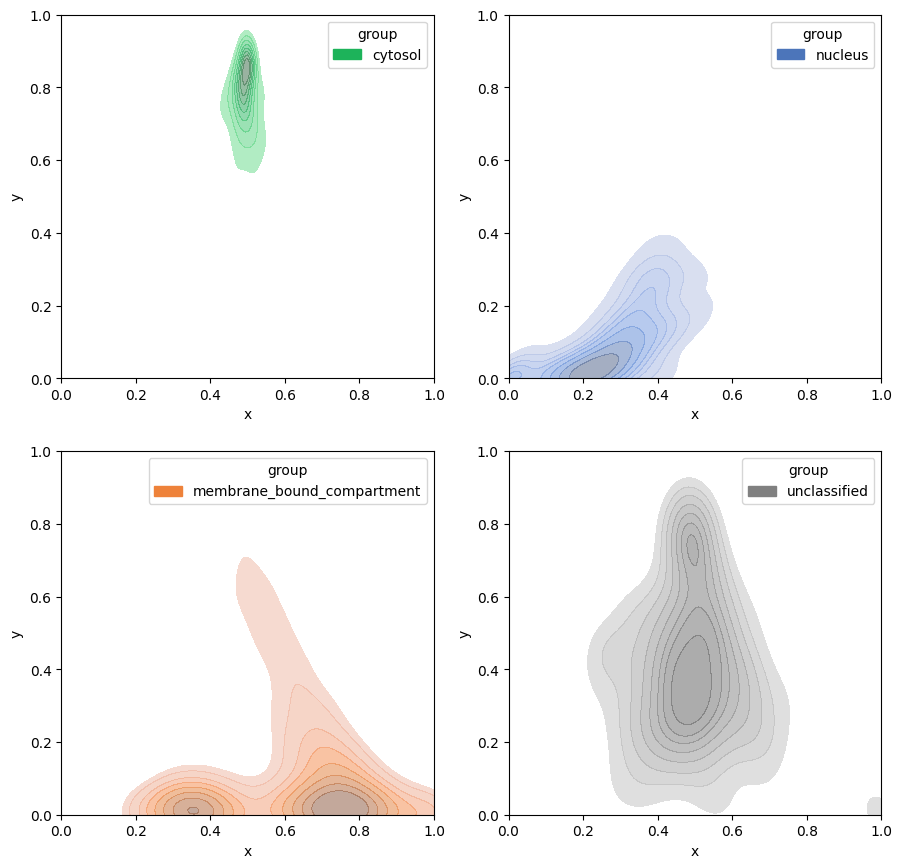

In [23]:
thres = 0.2 # Lowest iso-proportion level at which to draw a contour line
levels = 9 # Number of iso-proportion levels to draw

nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=2, ncols=2)  
fig.set_size_inches(10, 10) # Set the figure size to letter size (8.5 x 11 inches)
fig.subplots_adjust(left=0.08, bottom = 0.08) # set the left and bottom margin for x and y axis labels

groups = ["cytosol", "nucleus", "membrane_bound_compartment", "unclassified"]
colors = ["#1DB35A", "#4C75BA", "#EE823A", "grey"]

idx = 0
for r in range(nrows):
    for c in range(ncols):
        group = groups[idx]
        tmp_df = kde_df[kde_df["group"]==group]
        sns.kdeplot(data=tmp_df, x="x", y="y", hue="group",
                     fill=True, levels = levels, thresh=thres, alpha=0.5, palette=[colors[idx]],
                     ax = axs[r,c])
        axs[r,c].set_ylim(0, 1)
        axs[r,c].set_xlim(0, 1)
        idx += 1

fig.savefig( save_path / f"{timestamp}_percentile_contour_subplots.pdf", dpi=300, bbox_inches='tight', format="pdf")